# <center> Annual and Monthly MEF Comparisons to PJM Published Factors </center> 

In [1]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
from datetime import datetime

In [2]:
import tabula

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# LABELS_ORDERED = ['co2_kg', 'co2_dam',
#                   'so2_kg', 'so2_dam_ap2', 'so2_dam_eas',
#                   'nox_kg', 'nox_dam_ap2', 'nox_dam_eas',
#                   'pm25_kg', 'pm25_dam_ap2', 'pm25_dam_eas']
# FULL_DAMS = ['dam_ap2', 'dam_eas']
# LABELS_EMISSIONS = ['co2_kg', 'so2_kg', 'nox_kg', 'pm25_kg']
# LABELS_FULL = LABELS_ORDERED + FULL_DAMS
LABELS_FULL = ['co2_kg', 'so2_kg', 'nox_kg']

In [5]:
KG_IN_LB = 0.453592

## Read in data 

### Helpers 

In [6]:
def get_factor_df(kind='MEF', time='MonthTOD', region='PJM', fuel_type='FossilOnly'):
    kind_folder = 'mefs' if kind=='MEF' else 'aefs'
    
    # Read in file
    if fuel_type == 'FossilOnly':
        region_breakdown = 'isorto' if region == 'PJM' else 'nerc'
        df = pd.read_csv(os.path.join(os.pardir, 'factor_estimates', 'calculated_factors', kind_folder, time, 
                                      '{}_{}.csv'.format(region_breakdown, kind_folder)),
                         index_col=GROUPING_NAMES_COLS[time])
        df = df[df[region_breakdown] == region].drop(region_breakdown, axis=1)
    else:
        if region != 'PJM':
            raise NotImplementedError('fossil+non-emitting factors are only available for PJM')
        df = pd.read_csv(os.path.join(os.pardir, 'factor_estimates', 'calculated_factors', kind_folder, time, 
                                      'pjm_fplus_{}.csv'.format(kind_folder)),
                         index_col=GROUPING_NAMES_COLS[time])
        
    # Filter MEF columns
    if kind == 'MEF':
        df = df.drop([x for x in df.columns if '-r' in x or '-int' in x], axis=1)
        df.columns = [x.replace('-est', '') for x in df.columns]
        
    # Ensure columns have numeric type
    df = df.apply(pd.to_numeric, axis=1)
    
    return df

In [7]:
def read_report_factors(page, col_name, commas=False):
    co2 = tabula.read_pdf('20170317-2016-emissions-report.pdf', pages=page)
    co2.columns = ['Year'] + list(co2.columns[1:])
    co2['Year'] = co2.apply(lambda x: 2012 + x.index//3)
    co2.set_index(['Year', col_name], inplace=True)
    if commas: co2 = co2.applymap(lambda x: x.replace(',', ''))
    co2 = co2.apply(lambda x: pd.to_numeric(x))
    co2 = co2 * KG_IN_LB
    return co2

### By region/temporal scope 

In [8]:
GROUPING_NAMES = ['SeasonalTOD', 'MonthTOD', 'TOD', 'YearOnly', 'Month']
GROUPING_COLS = [['year', 'season', 'hour'], ['year', 'month', 'hour'], 
        ['year', 'hour'], ['year'], ['year', 'month']]
GROUPING_NAMES_COLS = dict(zip(GROUPING_NAMES, GROUPING_COLS))

In [9]:
all_dfs = {}
for kind in ['MEF', 'AEF']:
    for region in ['PJM']:
        for fuel_type in ['FossilOnly', 'FossilPlus']:
            for time in ['YearOnly', 'Month']:
                if kind == 'AEF' and fuel_type == 'FossilOnly':
                    continue
                print(kind, region, fuel_type, time)
                df = get_factor_df(kind=kind, time=time, region=region, fuel_type=fuel_type)
                all_dfs[(kind, 'Ours', fuel_type, time)] = df
                print(df.index.get_level_values('year').unique().values)    

MEF PJM FossilOnly YearOnly
[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
MEF PJM FossilOnly Month
[2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017]
MEF PJM FossilPlus YearOnly
[2016 2017]
MEF PJM FossilPlus Month
[2016 2017]
AEF PJM FossilPlus YearOnly
[2016 2017]
AEF PJM FossilPlus Month
[2016 2017]


## Load PJM EF data and put into data structures

In [10]:
co2 = read_report_factors(5, 'CO2 (lbs/MWh)', commas=True)
so2 = read_report_factors(6, 'SO2 (lbs/MWh)')
nox = read_report_factors(7, 'NOX (lbs/MWh)')

### Annual average 

In [11]:
pjm_df = pd.concat([co2[(co2.index.get_level_values(1) == 'PJM System Average')]['Annual'],
           so2[(so2.index.get_level_values(1) == 'PJM System Average')]['Annual'],
           nox[(nox.index.get_level_values(1) == 'PJM System Average')]['Annual']], axis=1)
pjm_df.index = list(range(2012, 2017))
pjm_df.columns = ['co2_kg', 'so2_kg', 'nox_kg']
all_dfs[('AEF', 'PJM', 'FossilPlus', 'YearOnly')] = pjm_df

### Annual marginal

In [12]:
pjm_on_df = pd.concat([co2[(co2.index.get_level_values(1) == 'Marginal On-Peak')]['Annual'],
           so2[(so2.index.get_level_values(1) == 'Marginal On-Peak')]['Annual'],
           nox[(nox.index.get_level_values(1) == 'Marginal On-Peak')]['Annual']], axis=1)
pjm_on_df.index = list(range(2012, 2017))
pjm_on_df.columns = ['co2_kg', 'so2_kg', 'nox_kg']
all_dfs[('MEF', 'PJM on-peak', 'FossilOnly', 'YearOnly')] = pjm_on_df

In [13]:
pjm_off_df = pd.concat([co2[(co2.index.get_level_values(1) == 'Marginal Off-Peak')]['Annual'],
           so2[(so2.index.get_level_values(1) == 'Marginal Off-Peak')]['Annual'],
           nox[(nox.index.get_level_values(1) == 'Marginal Off-Peak')]['Annual']], axis=1)
pjm_off_df.index = list(range(2012, 2017))
pjm_off_df.columns = ['co2_kg', 'so2_kg', 'nox_kg']
all_dfs[('MEF', 'PJM off-peak', 'FossilOnly', 'YearOnly')] = pjm_off_df

### Monthly average 

In [14]:
def get_monthly_vals(co2, label, value):
    df = co2[(co2.index.get_level_values(1) == value)].drop('Annual', axis=1)
    df.index = df.index.get_level_values(0)
    df.columns = list(range(1, 13))
    df = pd.DataFrame(df.stack())
    df.columns = [label]
    return df

In [15]:
l = []
for df, col in zip([co2, so2, nox], ['co2_kg', 'so2_kg', 'nox_kg']):
    mvals = get_monthly_vals(df, col, 'PJM System Average')
    l.append(mvals)
pjm_monthly_avg = pd.concat(l, axis=1)
all_dfs[('AEF', 'PJM', 'FossilPlus', 'Month')] = pjm_monthly_avg

### Monthly marginal 

In [16]:
l = []
for df, col in zip([co2, so2, nox], ['co2_kg', 'so2_kg', 'nox_kg']):
    mvals = get_monthly_vals(df, col, 'Marginal On-Peak')
    l.append(mvals)
pjm_monthly_on = pd.concat(l, axis=1)
all_dfs[('MEF', 'PJM on-peak', 'FossilOnly', 'Month')] = pjm_monthly_on

In [17]:
l = []
for df, col in zip([co2, so2, nox], ['co2_kg', 'so2_kg', 'nox_kg']):
    mvals = get_monthly_vals(df, col, 'Marginal Off-Peak')
    l.append(mvals)
pjm_monthly_off = pd.concat(l, axis=1)
all_dfs[('MEF', 'PJM off-peak', 'FossilOnly', 'Month')] = pjm_monthly_off

## Plots 

In [18]:
from matplotlib import gridspec
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

In [19]:
def format_idx(df, time):
    df_dt = df.copy()
    if time == 'Month':
        df_dt.index = df_dt.index.map(lambda x: datetime(x[0], x[1], 1))
    else:
        df_dt.index = df_dt.index.map(lambda x: datetime(x, 1, 1))
    return df_dt.loc[df_dt.index.year < 2017]  # restrict to 2016 or before

In [20]:
def plot_over_time_helper(label, df_dict, ax, time='YearOnly', legend=True, lgd_y=-0.09):    
    
    # Set x ticks
    xticks = pd.date_range(start='2006-01-01', end='2018-01-05', freq='AS')[:-1]
    xticks = xticks[::2]
    
    ours_mef = format_idx(df_dict[('MEF', 'Ours', 'FossilOnly', time)], time)
    pjm_onpeak_mef = format_idx(df_dict[('MEF', 'PJM on-peak', 'FossilOnly', time)], time)
    pjm_offpeak_mef = format_idx(df_dict[('MEF', 'PJM off-peak', 'FossilOnly', time)], time)

    ours_aef = format_idx(df_dict[('AEF', 'Ours', 'FossilPlus', time)], time)
    pjm_aef = format_idx(df_dict[('AEF', 'PJM', 'FossilPlus', time)], time)
    
    lw=2
    
    ours_mef[label].plot(ax=ax, yerr=ours_mef['{}-se'.format(label)], 
                         marker='s', markersize=4,
                         legend=False, label='Ours (fossil-only) (MEF)',
                         ls='-', mew=1, color='blue', xticks=xticks.to_pydatetime(), 
                    lw=lw)
    pjm_onpeak_mef[label].plot(ax=ax, #yerr=pjm_onpeak_mef['{}-se'.format(label)], 
                         marker='.', markersize=8,
                         legend=False, label='PJM on-peak (MEF)',
                         ls='-', mew=1, color='green', xticks=xticks.to_pydatetime(), 
                    lw=lw)
    pjm_offpeak_mef[label].plot(ax=ax, #yerr=pjm_offpeak_mef['{}-se'.format(label)], 
                         marker='^', markersize=4,
                         legend=False, label='PJM off-peak (MEF)',
                         ls='-', mew=1, color='red', xticks=xticks.to_pydatetime(), 
                    lw=lw)
    
    ours_aef[label].plot(ax=ax,
                         marker='s', markersize=4,
                         legend=False, label='Ours (fossil+non-emitting) (AEF)',
                         ls='-', mew=1, color='blue', markerfacecolor='white',
                  xticks=xticks.to_pydatetime(), 
                    lw=lw)
    pjm_aef[label].plot(ax=ax,
                         marker='d', markersize=4,
                         legend=False, label='PJM (AEF)',
                         ls='-', mew=1, color='purple', markerfacecolor='white',
                  xticks=xticks.to_pydatetime(), 
                    lw=lw)
                    
    # Format x- and y-axis label
    ylabel = 'Emissions factor\n(kg/MWh)'
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Year' if time == 'YearOnly' else 'Month/Year') 

    # Set x limits, x tick label format, and y limits
    ax.set_xlim('2012-01-01', '2017-01-05')
    ax.set_xticklabels([x.strftime('\'%y') for x in xticks])
#     ax.set_ylim(0,)

    # Font size
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)

    # Legend
    if legend:
        lgd_handles, lgd_labels = ax.get_legend_handles_labels()
        order = [4,2,0,3,1]   # hard-coded label order
        lgd = ax.legend([lgd_handles[idx] for idx in order],[lgd_labels[idx] for idx in order],
                  loc='center', bbox_to_anchor=(0.5, lgd_y), ncol=3, fontsize=12.5,
                    columnspacing=0.8, bbox_transform=plt.gcf().transFigure)
        return lgd
    else:
        return None

In [21]:
def plot_over_time_annual(label, all_dfs):
    fig, ax = plt.subplots(figsize=(8.5, 4))
    lgd = plot_over_time_helper(label, all_dfs, ax, time='YearOnly')
    
#     dirname = os.path.join('plots', 'annual_monthly')
#     if not os.path.exists(dirname): os.makedirs(dirname)
#     fig.savefig(os.path.join(dirname, '{}-annualOnly.pdf'.format(label)), 
#                 bbox_extra_artists=(lgd,), bbox_inches='tight')
    
def plot_over_time_monthly(label, all_dfs):
    fig, ax = plt.subplots(figsize=(8.5, 4))
    lgd = plot_over_time_helper(label, all_dfs, ax, time='Month')
    
#     dirname = os.path.join('plots', 'annual_monthly')
#     if not os.path.exists(dirname): os.makedirs(dirname)
#     fig.savefig(os.path.join(dirname, '{}-monthlyOnly.pdf'.format(label)), 
#                 bbox_extra_artists=(lgd,), bbox_inches='tight')
    
def plot_over_time_annual_monthly(label, all_dfs):
    fig, axes = plt.subplots(2, 1, figsize=(8.5, 7), sharey=True)
    lgd = plot_over_time_helper(label, all_dfs, axes[0], time='YearOnly', lgd_y=-0.03)
    plot_over_time_helper(label, all_dfs, axes[1], time='Month', legend=False)
    axes[0].set_ylim(0,)
    plt.tight_layout()
    
    dirname = os.path.join('pjm_factor_comparison')
    if not os.path.exists(dirname): os.makedirs(dirname)
    fig.savefig(os.path.join(dirname, '{}-pjm-comparison.pdf'.format(label)), 
                bbox_extra_artists=(lgd,), bbox_inches='tight')

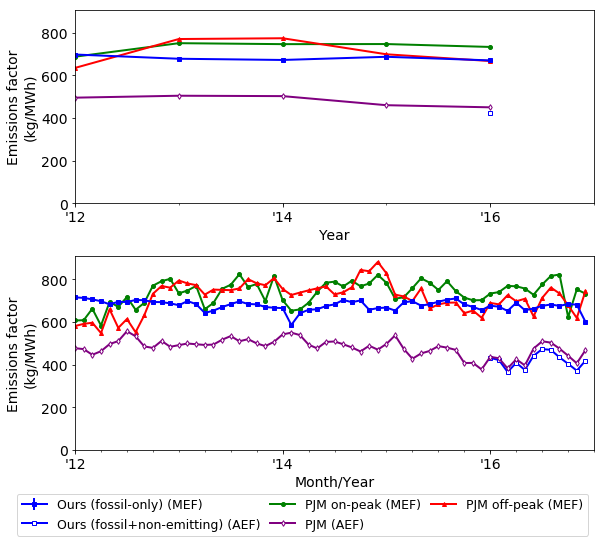

In [22]:
# TODO shared y axis -- propagate to annual/monthly plots
plot_over_time_annual_monthly('co2_kg', all_dfs)

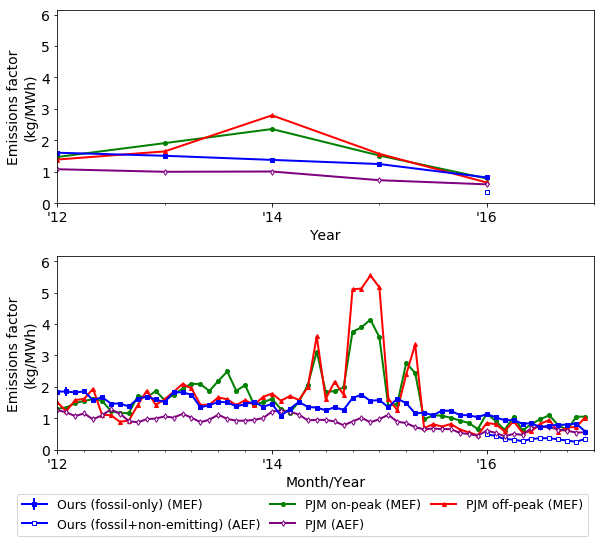

In [23]:
plot_over_time_annual_monthly('so2_kg', all_dfs)

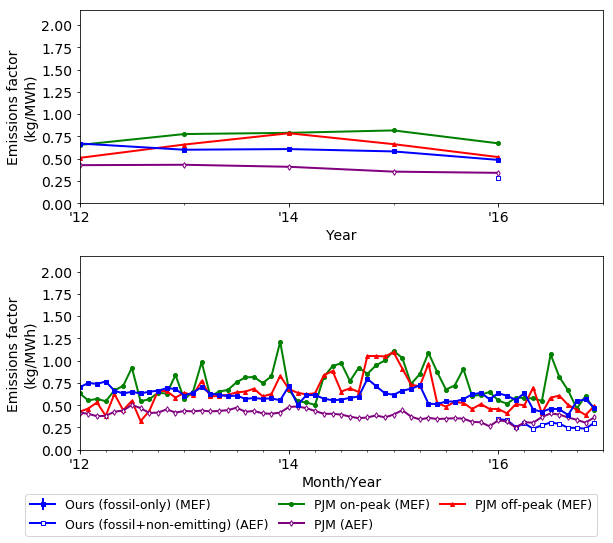

In [24]:
plot_over_time_annual_monthly('nox_kg', all_dfs)

## Stats

### Average factors 

In [25]:
(all_dfs[('AEF', 'PJM', 'FossilPlus', 'YearOnly')] / all_dfs[('AEF', 'Ours', 'FossilPlus', 'YearOnly')]).dropna(
    axis=1, how='all').dropna()

,co2_kg,nox_kg,so2_kg
2016,1.068367,1.203882,1.704054


### Marginal on-peak 

In [26]:
on_peak_comp = ((all_dfs[('MEF', 'PJM on-peak', 'FossilOnly', 'YearOnly')] / all_dfs[('MEF', 'Ours', 'FossilOnly', 'YearOnly')]).dropna(
    axis=1, how='all').dropna() * 100).round(0).astype(int) - 100
on_peak_comp

,co2_kg,nox_kg,so2_kg
2012,-1,-2,-8
2013,11,29,27
2014,11,30,71
2015,9,41,22
2016,9,38,-4


In [27]:
on_peak_comp.mean()

co2_kg     7.8
nox_kg    27.2
so2_kg    21.6
dtype: float64

### Marginal off-peak

In [28]:
off_peak_comp = ((all_dfs[('MEF', 'PJM off-peak', 'FossilOnly', 'YearOnly')] / all_dfs[('MEF', 'Ours', 'FossilOnly', 'YearOnly')]).dropna(
    axis=1, how='all').dropna() * 100).round(0).astype(int) - 100
off_peak_comp

,co2_kg,nox_kg,so2_kg
2012,-9,-24,-14
2013,14,10,9
2014,15,29,103
2015,2,14,26
2016,0,7,-20


In [29]:
off_peak_comp.mean()

co2_kg     4.4
nox_kg     7.2
so2_kg    20.8
dtype: float64

In [30]:
off_peak_comp.columns = ['{}-off'.format(x) for x in off_peak_comp.columns]
on_peak_comp.columns = ['{}-on'.format(x) for x in on_peak_comp.columns]

In [31]:
pd.concat([off_peak_comp, on_peak_comp], axis=1)[['co2_kg-on', 'co2_kg-off', 'so2_kg-on', 'so2_kg-off', 
                                                  'nox_kg-on', 'nox_kg-off']]

,co2_kg-on,co2_kg-off,so2_kg-on,so2_kg-off,nox_kg-on,nox_kg-off
2012,-1,-9,-8,-14,-2,-24
2013,11,14,27,9,29,10
2014,11,15,71,103,30,29
2015,9,2,22,26,41,14
2016,9,0,-4,-20,38,7


In [32]:
print(pd.concat([off_peak_comp, on_peak_comp], axis=1)[['co2_kg-on', 'co2_kg-off', 'so2_kg-on', 'so2_kg-off', 
                                                  'nox_kg-on', 'nox_kg-off']].to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  co2\_kg-on &  co2\_kg-off &  so2\_kg-on &  so2\_kg-off &  nox\_kg-on &  nox\_kg-off \\
\midrule
2012 &         -1 &          -9 &         -8 &         -14 &         -2 &         -24 \\
2013 &         11 &          14 &         27 &           9 &         29 &          10 \\
2014 &         11 &          15 &         71 &         103 &         30 &          29 \\
2015 &          9 &           2 &         22 &          26 &         41 &          14 \\
2016 &          9 &           0 &         -4 &         -20 &         38 &           7 \\
\bottomrule
\end{tabular}

